## Runing the Linear AA on the MNIST dataset


In [1]:

import torch
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt 
from scipy.spatial.distance import squareform, pdist
from src.methods.AALS import AALS 
from itertools import combinations
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import umap

/opt/anaconda3/envs/sae_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

N_ARCHETYPES = 3
N_RUNS = 5

SAVE_DIR = 'results/MNIST_5runs'
os.makedirs(SAVE_DIR, exist_ok=True)

## Load MNIST data

In [3]:

# 1. Load and Preprocess MNIST (The "Binary" way)
print("Loading MNIST...")
transform = transforms.Compose([transforms.ToTensor(), transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_all = mnist.data.numpy()
data_all = data_all / 255
data_all = (data_all * 2) - 1 # norm
labels = mnist.targets.numpy()

print("MNIST Loaded. Data shape:", data_all.shape)

Loading MNIST...
MNIST Loaded. Data shape: (60000, 28, 28)


In [4]:

# Pick single digitw
digit = 4

# Select data for the specified digit
idx_digit = mnist.targets.numpy() == digit

# Create dataset for the selected digit
data_digit = data_all[idx_digit,]

# Reshape data to 2D array (samples x features)
data_digit = np.reshape(data_digit, (data_digit.shape[0], -1))

# Print shape of the digit-specific dataset
print(data_digit.shape)

# Added a transposoition to ensure final shape
X = torch.tensor(data_digit, dtype=torch.float64).transpose(0, 1)

(5842, 784)


(5842, 784) means we have 5842 samples of digit '4', each flattened to 784 features

## Gaussian Method

In [5]:
S_list = []
C_list = []
L_list = []  # <-- store the losses

for run in range(N_RUNS):
    print(f"Run {run+1}/{N_RUNS}")
    
    C_run, S_run, L_run, EV = AALS(X, N_ARCHETYPES)  # Your Linear AA function
    
    # Append to lists
    S_list.append(S_run.detach().cpu().numpy() if isinstance(S_run, torch.Tensor) else S_run)
    C_list.append(C_run.detach().cpu().numpy() if isinstance(C_run, torch.Tensor) else C_run)
    L_list.append(L_run)

# Save everything
torch.save({'C': C_list, 'S': S_list, 'L': L_list}, os.path.join(SAVE_DIR, 'mnist_gaussian_aa_results.pth'))


Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


---

## Visualize the results

In [6]:
# Open the saved results to verify
results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/LinearAA/Python/results/MNIST_5runs/mnist_gaussian_aa_results.pth', weights_only=False)
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C'][0].shape)
print("Shape of S in first run:", results['S'][0].shape)
print("Length of Losses in first run:", len(results['L'][0]))

Saved Results Keys: dict_keys(['C', 'S', 'L'])
Number of Runs Saved: 5
Shape of C in first run: (5842, 3)
Shape of S in first run: (3, 5842)
Length of Losses in first run: 23


# Metric Formulas

In [10]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [11]:
from itertools import combinations

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C']]
print("C_matrices length:", len(C_matrices))
S_matrices = [to_numpy(S) for S in results['S']]
print("C_matrices length:", len(C_matrices))
X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Linear AA 5-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 5
C_matrices length: 5
---
Linear AA 5-run stability:
---
Mean NMI: 0.999173054583444
Mean Archetype Consistency: 0.9999994208568423
Mean ISI: 0.01230146085008011


---

# Archetypal Analysis

In [12]:
# Select archetypes to visualize from the loaded results
C_linear = results['C'][0]
S_linear = results['S'][0]

print("C_linear shape:", C_linear.shape)
print("S_linear shape:", S_linear.shape)

C_linear shape: (5842, 3)
S_linear shape: (3, 5842)


### Visualizing the Archetypes

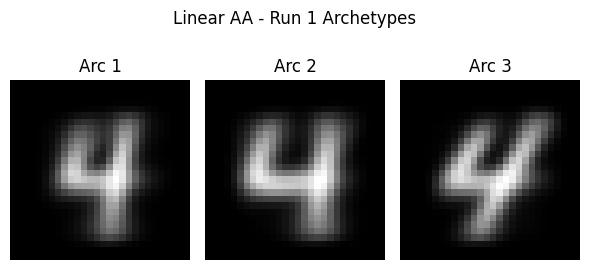

In [13]:
def to_numpy(tensor):
    """Convert tensor to numpy array if needed."""
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def plot_archetypes(C, img_shape=(28,28), title="Archetypes"):
    # C is (features × archetypes)
    C = to_numpy(C)
    n_archetypes = C.shape[1]
    
    fig, axes = plt.subplots(1, n_archetypes, figsize=(2*n_archetypes, 3))
    for i in range(n_archetypes):
        img = C[:, i].reshape(img_shape)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Arc {i+1}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Transpose X_raw to (samples, features)
X_samples = X_raw.T 

# Reconstruct archetypes (features × archetypes)
C_recon = X_samples.T @ S_matrices[0].T  # (784, 3)

plot_archetypes(C_recon, img_shape=(28,28), title="Linear AA - Run 1 Archetypes")



/opt/anaconda3/envs/sae_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


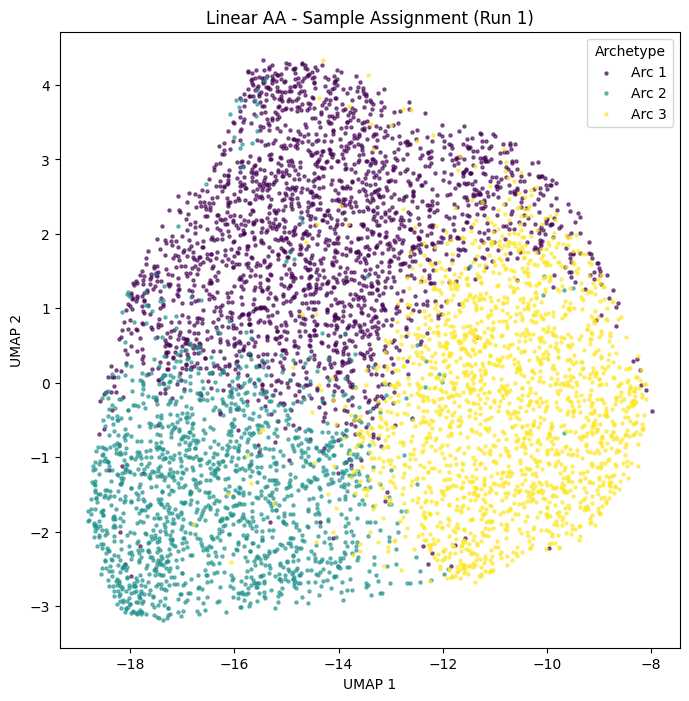

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import umap

def plot_umap_assignment(X, S, title="Sample Assignment", s=5, alpha=0.6, cmap='viridis'):
    # Convert S to numpy if tensor
    S = to_numpy(S)
    X = to_numpy(X)

    # Step 1: compute dominant archetype for each sample
    dominant_arc = np.argmax(S, axis=0)  # shape: (N_samples,)

    # Step 2: reduce X to 2D using UMAP
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
    X_embedded = reducer.fit_transform(X)  # shape: (N_samples, 2)

    # Step 3: scatter plot colored by dominant archetype
    n_archetypes = S.shape[0]
    plt.figure(figsize=(8,8))

    # Get the colormap
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, n_archetypes))

    # Plot each archetype separately to create a legend
    for i in range(n_archetypes):
        plt.scatter(
            X_embedded[dominant_arc==i, 0],
            X_embedded[dominant_arc==i, 1],
            color=colors[i],
            s=s,
            alpha=alpha,
            label=f"Arc {i+1}"
        )

    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Archetype")
    plt.show()

# Example usage:
plot_umap_assignment(X_samples, S_matrices[0], title="Linear AA - Sample Assignment (Run 1)")



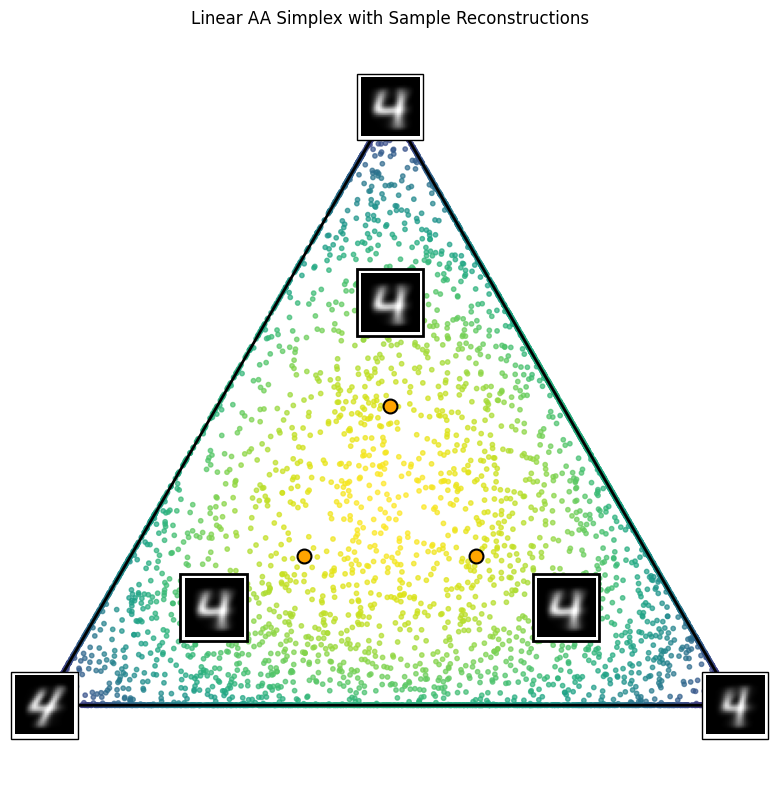

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import entropy

def plot_simplex_with_samples(S, C=None, title="Simplex Plot", s=10, cmap='viridis', 
                               show_archetypes=True, sample_points=None, img_shape=(28, 28),
                               zoom=1.5):
    S = np.array(S)
    k, N = S.shape
    if k != 3:
        raise ValueError("Simplex plot only works for k=3 archetypes")
    
    # Auto-detect and fix C orientation
    if C is not None:
        C = np.array(C)
        if C.shape[0] == 3 and C.shape[1] != 3:
            C = C.T
        elif C.shape[0] != np.prod(img_shape):
            print(f"Warning: C shape {C.shape} may not match img_shape {img_shape}")
    
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    X_simplex = S.T @ vertices  # shape: (N, 2)
    
    mix_strength = np.array([entropy(S[:, i]) for i in range(N)])
    mix_strength /= np.log(3)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(X_simplex[:, 0], X_simplex[:, 1], c=mix_strength, 
                cmap=cmap, s=s, alpha=0.7)
    triangle = Polygon(vertices, fill=False, linewidth=2)
    plt.gca().add_patch(triangle)
    
    if show_archetypes and C is not None:
        for i in range(3):
            img = C[:, i].reshape(img_shape)
            im_box = OffsetImage(img, zoom=zoom, cmap='gray')
            ab = AnnotationBbox(im_box, vertices[i], frameon=True, pad=0.3)
            plt.gca().add_artist(ab)
    
    if sample_points is not None and C is not None:
        for weights in sample_points:
            weights = np.array(weights)
            weights = weights / weights.sum()
            pos_2d = weights @ vertices
            reconstructed = C @ weights
            img = reconstructed.reshape(img_shape)
            plt.scatter(pos_2d[0], pos_2d[1], c='orange', s=100, 
                       marker='o', edgecolors='black', linewidths=1.5, zorder=10)
            offset = pos_2d - np.array([0.5, np.sqrt(3)/6])
            offset = offset / np.linalg.norm(offset) * 0.15
            ab = AnnotationBbox(im_box, pos_2d + offset, frameon=True, 
                               pad=0.3, bboxprops=dict(linewidth=2))
            plt.gca().add_artist(ab)
    
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example barycentric sample points
sample_points = [
    (0.1, 0.05, 0.05),  # Near archetype 0
    (0.05, 0.1, 0.05),  # Near archetype 1
    (0.05, 0.05, 0.1)   # Near archetype 2
]

plot_simplex_with_samples(S_matrices[0], C=C_recon, 
                          title="Linear AA Simplex with Sample Reconstructions",
                          sample_points=sample_points)



In [52]:
import numpy as np

# Choose sample indices once
n_samples = 5
np.random.seed(42)  # for reproducibility
selected_indices = np.random.choice(X_samples.shape[0], n_samples, replace=False)
print("Selected sample indices for visualization:", selected_indices)
# Save these indices to reuse in other notebooks
np.save("selected_indices.npy", selected_indices)


Selected sample indices for visualization: [4584  177  167 5585 2339]


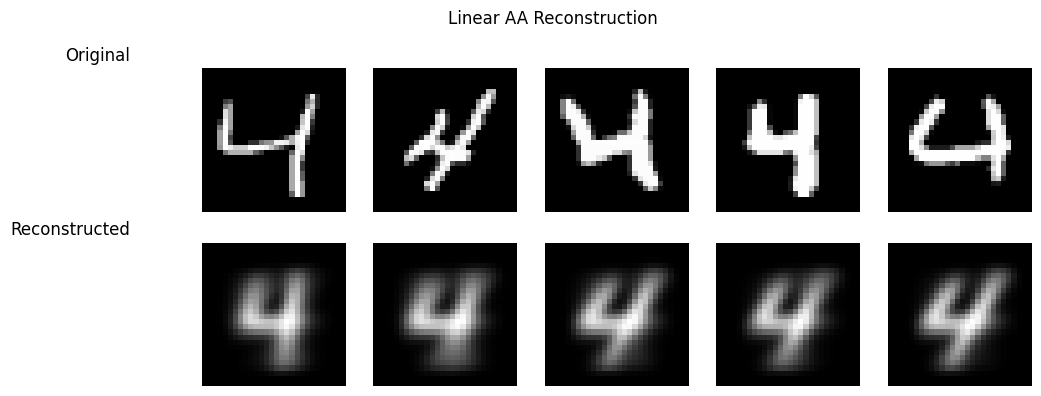

In [53]:
def plot_reconstruction_flat(X_orig, X_recon, n_samples=5, img_shape=(28,28), title="Reconstruction"):
    """
    Visualize original samples and their reconstructions for given indices.

    X_orig: (samples, features)
    X_recon: (samples, features)
    n_samples: number of samples to show (default 5)
    img_shape: shape to reshape each sample (default (28,28))
    title: plot title
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(2*n_samples, 4))

    for i in range(n_samples):
        idx = i
        # Original
        axes[0, i].imshow(X_orig[idx].reshape(img_shape), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Original", x=-0.5, ha='right')

        # Reconstructed without clipping
        rec = X_recon[idx].reshape(img_shape)
        axes[1, i].imshow(rec, cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Reconstructed", x=-0.5, ha='right')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Make sure X_raw is (samples, features)
X_samples = X_raw.T  # shape: (5842, 784)
C_recon = X_samples.T @ S_matrices[0].T  # (784, k)

# Reconstruct samples
X_rec = (C_recon @ S_matrices[0]).T 

import numpy as np

# save the reconstructions
import numpy as np
np.save("X_rec_LINEAR.npy", X_rec)
np.save("X_samples.npy", X_samples)

selected_indices = np.load("selected_indices.npy")

from scipy.stats import entropy

# Calculate how "mixed" each sample is
mix_strength = np.array([entropy(S_matrices[0][:, i]) for i in range(S_matrices[0].shape[1])])
mix_strength /= np.log(N_ARCHETYPES)  # normalize

# Show samples with low mixing (close to pure archetypes)
pure_samples = [0, 1, 2, 5, 6, 13, 18, 20, 22, 30]

# For Linear AA reconstruction plotting
plot_reconstruction_flat(X_samples[pure_samples], X_rec[selected_indices],
                         n_samples=len(selected_indices), title="Linear AA Reconstruction")




### Calculating the reconstructions

In [54]:
import numpy as np
import torch

def to_numpy(x):
    return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)

def normalize_S(S, N):
    """Ensure S has shape (K, N)."""
    S = to_numpy(S)
    if S.shape[1] == N:
        return S             # already (K, N)
    if S.shape[0] == N:
        return S.T           # was (N, K)
    raise ValueError(f"Cannot reshape S. Got {S.shape}, expected (K,N) or (N,K).")

def compute_C_from_S(X_raw, S):
    """C = X Sᵀ (S Sᵀ)^(-1). Produces (D, K)."""
    SST = S @ S.T
    return X_raw @ S.T @ np.linalg.pinv(SST)

def reconstruct(X_raw, C_saved, S_saved):
    """
    Reconstruct X using saved S and (maybe) saved C.
    Returns X_rec (N,D), C_features (D,K), S_kxn (K,N).
    """
    X_raw = to_numpy(X_raw)        # (D, N)
    D, N = X_raw.shape

    S = normalize_S(S_saved, N)    # (K, N)
    K = S.shape[0]

    C_saved = to_numpy(C_saved)

    # If C is not (D,K), recompute from X and S
    if C_saved.shape != (D, K):
        C_feat = compute_C_from_S(X_raw, S)
    else:
        C_feat = C_saved

    # Reconstruction: (D,K)(K,N) = (D,N) → transpose → (N,D)
    X_rec = (C_feat @ S).T
    return X_rec, C_feat, S

def mse_metrics(X_true, X_rec):
    X_true = np.asarray(X_true)
    X_rec  = np.asarray(X_rec)

    N, D = X_true.shape
    residuals = X_true - X_rec

    SSE = np.sum(residuals**2)
    MSE = SSE / (N * D)
    RMSE = np.sqrt(MSE)

    mean_x = X_true.mean(axis=0)
    SST = np.sum((X_true - mean_x)**2)
    R2 = 1 - SSE/SST if SST > 0 else np.nan

    return dict(MSE=MSE, RMSE=RMSE, R2=R2)


In [55]:
# Calculate average reconstruction metrics across all runs for Linear AA

all_metrics = []
for i in range(N_RUNS):
    # Reconstruct for each run
    X_rec_i, _, _ = reconstruct(X_samples.T, results['C'][i], results['S'][i])
    metrics_i = mse_metrics(X_samples, X_rec_i)
    all_metrics.append(metrics_i)

# Compute averages
avg_metrics = {
    'MSE': np.mean([m['MSE'] for m in all_metrics]),
    'RMSE': np.mean([m['RMSE'] for m in all_metrics]),
    'R2': np.mean([m['R2'] for m in all_metrics])
}

print("LINEAR AA on MNIST\nAverage Reconstruction Metrics (across all runs):", avg_metrics)

LINEAR AA on MNIST
Average Reconstruction Metrics (across all runs): {'MSE': 0.16643856342691965, 'RMSE': 0.4079688265286926, 'R2': 0.2018570305770142}
